# mT5

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import MT5TokenizerFast, MT5ForConditionalGeneration

/home/nlp/anaconda3/envs/vietnq-ner/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LENGTH = 1024
model_id = 'google/mt5-base'

In [3]:
# Setup tokenizer
tokenizer = MT5TokenizerFast.from_pretrained(model_id)

print('BOS:', tokenizer.bos_token)
print('SEP:', tokenizer.sep_token)
print('PAD:', tokenizer.pad_token)
print('EOS:', tokenizer.eos_token)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/nlp/anaconda3/envs/vietnq-ner/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


BOS: None
SEP: None
PAD: <pad>
EOS: </s>


### 1. Dataset `Universal-NER/Pile-NER-type`

#### Load dataset

In [4]:
# output repo in huggingface
output_repo = 'en-mT5-ner-open_domain'

In [5]:
en_open_ner = load_dataset('Universal-NER/Pile-NER-type', split='train')
en_open_ner

Dataset({
    features: ['conversations', 'id'],
    num_rows: 45889
})

In [6]:
en_open_ner[232]

{'conversations': [{'from': 'human',
   'value': 'Text: N-(X-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide (with X = 2 and 4). The structures of N-(2-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide and N-(4-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide, both C16H13ClN2O4S, are stabilized by extensive intramolecular hydrogen bonds. The 4-chloro derivative forms dimeric pairs of molecules lying about inversion centres as a result of intermolecular N-H...O hydrogen bonds, forming 14-membered rings representing an R2(2)(14) motif; the 2-chloro derivative is devoid of any such intermolecular hydrogen bonds. The heterocyclic thiazine rings in both structures adopt half-chair conformations.'},
  {'from': 'gpt', 'value': "I've read this text."},
  {'from': 'human', 'value': 'What describes Relationship in the text?'},
  {'from': 'gpt', 'value': '[]'},
  {'from': 'human', 'value': 'What describes

#### Make instruction dataset and clean it

In [7]:
def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction: {instruction}\n\n### Input: {input}\n\n### Response:\n").format_map(row)

In [8]:
# Make instruction data
def make_instruction_data(samples):
    ids, texts, labels, entity_types, input_paras = [], [], [], [], []

    for sample_id, sample_conv in zip(samples['id'], samples['conversations']):
        cur_input_para = sample_conv[0]['value'].strip()
        for i in range(2, len(sample_conv), 2):
            cur_id = str(sample_id) + '_' + str(i//2)

            user_question = sample_conv[i]['value'].strip()
            cur_entity_type = re.search(r'(?<=describes\s)(.*?)(?=\sin)', user_question).group(0).strip()
            cur_instruction = user_question.replace(cur_entity_type, cur_entity_type.lower())
            cur_text = prompt_input({
                'instruction': cur_instruction,
                'input': cur_input_para,
            })

            cur_label = sample_conv[i+1]['value'].strip()

            ids.append(cur_id)
            texts.append(cur_text)
            labels.append(cur_label)
            entity_types.append(cur_entity_type)
            input_paras.append(cur_input_para)
    return {
        'id': ids,
        'text': texts,
        'label': labels,
        'entity_type': entity_types,
        'input_para': input_paras,
    }

print("> Making instruction dataset...")
en_open_ner_instruct = en_open_ner.map(
    make_instruction_data, batched=True, remove_columns=en_open_ner.column_names
)
print("labelled ds:", en_open_ner_instruct)

> Making instruction dataset...
labelled ds: Dataset({
    features: ['id', 'text', 'label', 'entity_type', 'input_para'],
    num_rows: 358181
})


In [9]:
df_raw = pd.DataFrame(en_open_ner_instruct)
df_raw

,id,text,label,entity_type,input_para
0,ner_0_1,"Below is an instruction that describes a task,...","[""function""]",programming concept,Text: Q:\n\nPosition character based on enemy ...
1,ner_0_2,"Below is an instruction that describes a task,...","[""lua""]",programming language,Text: Q:\n\nPosition character based on enemy ...
2,ner_0_3,"Below is an instruction that describes a task,...",[],database,Text: Q:\n\nPosition character based on enemy ...
3,ner_0_4,"Below is an instruction that describes a task,...","[""myPosition"", ""enemyPosition"", ""xValue"", ""yVa...",variable,Text: Q:\n\nPosition character based on enemy ...
4,ner_0_5,"Below is an instruction that describes a task,...",[],Date,Text: Q:\n\nPosition character based on enemy ...
...,...,...,...,...,...
358176,ner_45888_10,"Below is an instruction that describes a task,...","[""factorial analyses of variance""]",method,Text: Automatic and Controlled Emotion Regulat...
358177,ner_45888_11,"Below is an instruction that describes a task,...",[],Person,Text: Automatic and Controlled Emotion Regulat...
358178,ner_45888_12,"Below is an instruction that describes a task,...","[""young adults"", ""older adults""]",group,Text: Automatic and Controlled Emotion Regulat...
358179,ner_45888_13,"Below is an instruction that describes a task,...",[],email,Text: Automatic and Controlled Emotion Regulat...


In [10]:
type(df_raw['label'][0])

str

In [11]:
df = df_raw.copy()
df['entity_type_lower'] = df['entity_type'].str.lower()

In [12]:
counts = df['entity_type'].value_counts(sort=True)
counts.size, counts[:20]

(15461,
 entity_type
 person          13706
 Person          11857
 organization    11831
 Organization    11157
 location        10196
 Location         9479
 concept          7523
 Date             6304
 product          6262
 date             5071
 event            3773
 group            3701
 technology       3463
 Event            3032
 object           3015
 software         2892
 Product          2821
 measurement      2624
 Nationality      2571
 variable         2522
 Name: count, dtype: int64)

In [13]:
counts = df['entity_type_lower'].value_counts(sort=True)
counts.size, counts[:20]

(12870,
 entity_type_lower
 person               25929
 organization         23231
 location             19888
 date                 11742
 concept               9908
 product               9178
 event                 6887
 technology            4866
 group                 4530
 medical condition     3853
 nationality           3610
 object                3602
 software              3502
 disease               3212
 measurement           3131
 time                  2954
 title                 2851
 country               2757
 variable              2670
 process               2561
 Name: count, dtype: int64)

In [14]:
# No negative examples vs total
df[df['label'] == '[]'].shape[0], df.shape[0]

(119862, 358181)

In [15]:
cleaned_df = df.drop_duplicates(subset=['input_para', 'entity_type_lower', 'label'])
df.shape, cleaned_df.shape

((358181, 6), (354402, 6))

In [17]:
en_open_ner_cleaned = Dataset.from_pandas(cleaned_df[['id', 'text', 'label']], preserve_index=False)
en_open_ner_cleaned

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 354402
})

#### Convey the lengths of samples in dataset

Map:  12%|█▏        | 41000/354402 [00:05<00:43, 7157.06 examples/s]

Map: 100%|██████████| 354402/354402 [00:45<00:00, 7839.64 examples/s]


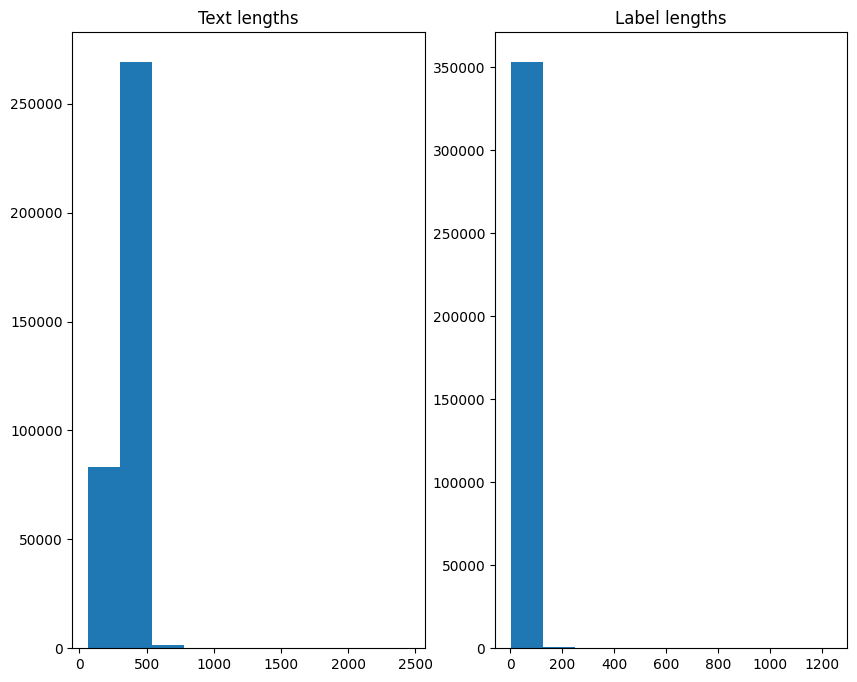

Max text length: 2449
Max label length: 1237
Current limit: MAX_LENGTH = 1024


In [18]:
en_open_ner_cleaned_with_length = en_open_ner_cleaned.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(en_open_ner_cleaned_with_length['len_text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(en_open_ner_cleaned_with_length['len_label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(en_open_ner_cleaned_with_length['len_text']))
print('Max label length:', max(en_open_ner_cleaned_with_length['len_label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

Drop those samples that having lengths exceed the pre-defined MAX LENGTH

In [19]:
en_open_ner_cleaned_dropped = en_open_ner_cleaned_with_length.filter(
    lambda example: (example['len_text'] <= MAX_LENGTH) and (example['len_label'] <= MAX_LENGTH)
)

Filter: 100%|██████████| 354402/354402 [00:01<00:00, 272884.58 examples/s]


Map:   1%|          | 2000/354261 [00:00<00:37, 9405.65 examples/s]

Map: 100%|██████████| 354261/354261 [00:49<00:00, 7141.90 examples/s]


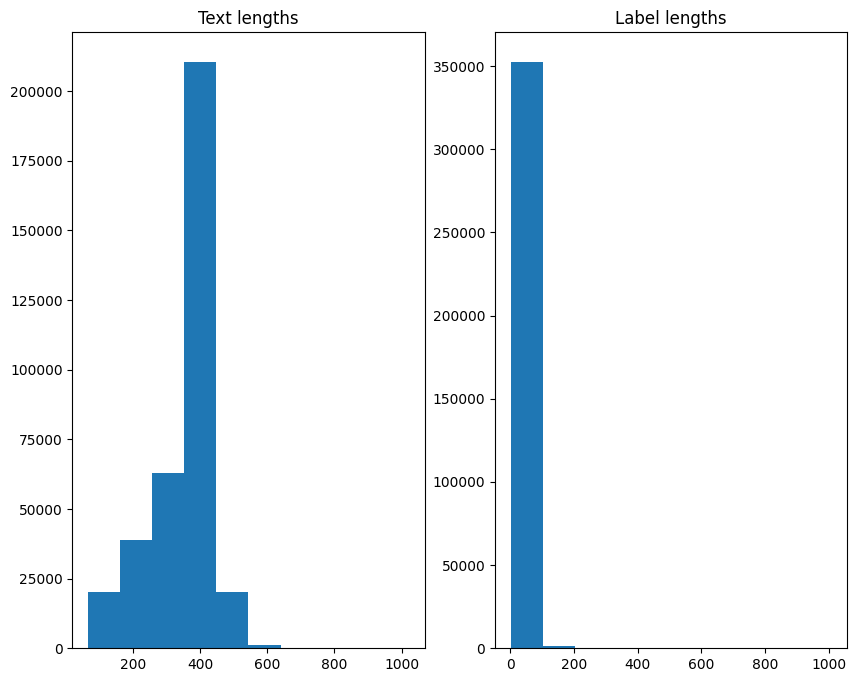

Max text length: 1021
Max label length: 1008
Current limit: MAX_LENGTH = 1024


In [20]:
token_lengths = en_open_ner_cleaned_dropped.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(token_lengths['len_text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(token_lengths['len_label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(token_lengths['len_text']))
print('Max label length:', max(token_lengths['len_label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [21]:
en_open_ner_cleaned_dropped

Dataset({
    features: ['id', 'text', 'label', 'len_text', 'len_label'],
    num_rows: 354261
})

#### Create tokenized dataset

In [22]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
en_open_ner_tokenized = en_open_ner_cleaned_dropped.map(
    lambda x: tokenize(x, tokenizer, "text", "label"),
    batched=True,
    remove_columns=["text", "label", "len_text", "len_label"],
)

print(">> Dataset is ready:")
print(en_open_ner_tokenized)

> Tokenizing dataset...


Map: 100%|██████████| 354261/354261 [01:11<00:00, 4925.24 examples/s]

>> Dataset is ready:
Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 354261
})


In [23]:
tokenizer.decode(en_open_ner_tokenized[19]['input_ids'])

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: What describes norp in the text? ### Input: Text: Gino Mäder Gino Mäder (born 4 January 1997) is a Swiss road and track cyclist, who currently rides for UCI WorldTeam. He competed at the 2016 UEC European Track Championships in the team pursuit event. Major results 2014 4th Road race, European Junior Road Championships 9th Overall Grand Prix Rüebliland 9th Overall Tour du Pays de Vaud 2015 1st Time trial, National Junior Road Championships 2nd Overall Tour du Pays de Vaud 1st Prologue & Stage 1 2nd Overall Grand Prix Rüebliland 5th Time trial, UCI Junior Road World Championships 2017 3rd Piccolo Giro di Lombardia 6th Rund um den Finanzplatz Eschborn-Frankfurt U23 2018 Tour Alsace 1st Points classification 1st Stage 4 1st Stage 4 Ronde de l'Isard 2nd Time trial, National Under–23 Road Championships 2nd Overall Tou

In [24]:
tokenizer.decode(en_open_ner_tokenized[19]['labels'])

'[]</s>'

In [26]:
print(f"> Pushing to hub: {output_repo}")
en_open_ner_tokenized.push_to_hub(output_repo)

> Pushing to hub: en-mT5-ner-open_domain


Uploading the dataset shards: 100%|██████████| 2/2 [00:23<00:00, 11.53s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/en-mT5-ner-open_domain/commit/00f95c52a945b0c5dc66cb9a5ea6b50b8984988f', commit_message='Upload dataset', commit_description='', oid='00f95c52a945b0c5dc66cb9a5ea6b50b8984988f', pr_url=None, pr_revision=None, pr_num=None)